In [184]:
#Импортируем все нужные данные
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import pandas as pd

from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from tqdm.autonotebook import tqdm
import warnings
import gc
import os

In [119]:
warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

Загрузим данные и проведем их анализ

In [30]:
data = pd.read_csv('/kaggle/input/spam-dataset/train_spam.csv')

In [31]:
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


Пропусков нет, ничего удалять не нужно

<Axes: >

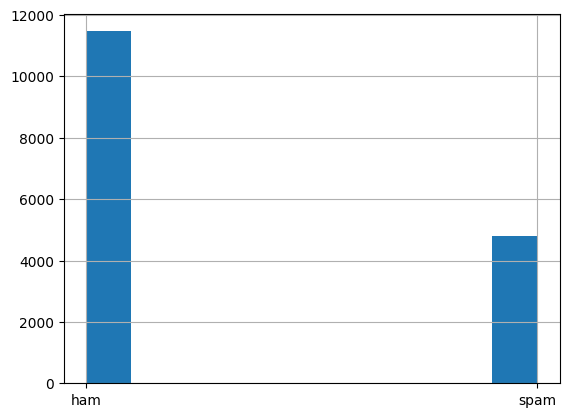

In [33]:
data['text_type'].hist()

Видим, что классы не сбалансированы, может потребоваться коррекция данных для обучения

Создададим датасет для удобной загрузки файлов

In [35]:
class SpamDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.texts = data['text']
        if mode != 'test':
            mapping = {
                'ham': 0,
                'spam': 1
            }
            self.labels = data['text_type'].map(mapping)
            
    def __getitem__(self, index):
        text = self.texts.iloc[index]
        if self.mode != 'test':
            label = self.labels.iloc[index]
            return (text, label)
        else:
            return text
        
    def __len__(self):
        return len(self.texts)

В качестве бейзлайна возьмем классический предобученный bert-base-uncased (так как данные на английском языке, мультиязыковые модификации не нужны) с зафиксированными весами и одним линейным слоем с одним выходом.<br>

Создадим класс модели для этого

In [36]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, tokenizer, model):
        super(BertBinaryClassifier, self).__init__()
        self.tokenizer = tokenizer
        self.model = model
        for param in model.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        if type(x) == tuple:
            outputs = []
            for sentence in x:
                encoded_input = self.tokenizer(sentence, return_tensors='pt', truncation=True).to(device)
                bert_output = self.model(**encoded_input)
                model_output = self.classifier(bert_output.pooler_output)
                probability = self.activation(model_output)
                outputs.append(probability)
            outputs = torch.concat(outputs).view(-1)
            return outputs
        else:
            encoded_input = self.tokenizer(x, return_tensors='pt').to(device)
            bert_output = self.model(**encoded_input)
            model_output = self.classifier(bert_output.pooler_output)
            probability = self.activation(model_output).view(-1)
            return probability

Основная метрика оценки качества - roc-auc, но также будем выводить balanced accuracy и confusion matrix для более точного понимания характеристик модели и отслеживания возможного дизбаланса классов при обучении. 

In [37]:
def train(model, dataloaders, n_epochs, criterion, optimizer, scheduler=None, device='cpu', backup_freq=None, init_epoch=0):
    best_model_wts = model.state_dict()
    best_roc_auc = 0.0
    best_epoch = 0
    model.to(device)
    print('Training')
    try:
        for epoch in tqdm(range(init_epoch, n_epochs)):
            print(f'Epoch {epoch+1}')
            for phase in ('train', 'val'):
                mean_loss = 0
                mean_roc_auc = 0
                conf_matrix = 0
                num_iters = 0
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                for batch in tqdm(dataloaders[phase]):
                    texts, labels = batch
                    labels = labels.to(torch.float32).to(device)
                    if phase == 'train':
                        preds = model(texts)
                    else:
                        with torch.no_grad():
                            preds = model(texts)
                    loss = criterion(preds, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    labels = labels.cpu()
                    preds = preds.detach().cpu()
                    mean_roc_auc += roc_auc_score(labels, preds)
                    conf_matrix += confusion_matrix(labels, preds.round(), labels=[0, 1], normalize='true')
                    mean_loss += loss
                    num_iters += 1
                balanced_accuracy = conf_matrix[[0, 1], [0, 1]].mean()
                print(f'{phase} loss: {mean_loss/num_iters}')
                print(f'{phase} roc-auc: {mean_roc_auc/num_iters}')
                print(f'{phase} balanced accuracy: {balanced_accuracy/num_iters}')
                print(f'{phase} confusion_matrix:\n{conf_matrix/num_iters}')
            if scheduler:
                if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
                    scheduler.step(mean_loss/num_iters)
                else:
                    scheduler.step()
            if mean_roc_auc/num_iters > best_roc_auc:
                best_roc_auc = mean_roc_auc/num_iters
                best_epoch = epoch
                best_model_wts = model.state_dict()
            if backup_freq:
                if (epoch+1) % backup_freq == 0:
                    model.save(epoch)
    except KeyboardInterrupt:
        print(f'Best val roc-auc: {best_roc_auc} (epoch {best_epoch + 1})')
        model.load_state_dict(best_model_wts)
        return model
    except Exception as e:
        print(f'Best val roc-auc: {best_roc_auc} (epoch {best_epoch + 1})')
        model.load_state_dict(best_model_wts)
        raise e
    print(f'Best val roc-auc: {best_roc_auc} (epoch {best_epoch + 1})')
    model.load_state_dict(best_model_wts)
    return model

Разделим данные на тренировочную и валидационную выборки и создадим объекты Datasset и DataLoader для загрузки данных в модель

In [38]:
data_train, data_val = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)

In [39]:
datasets = {
    'train': SpamDataset(data_train, mode='train'),
    'val': SpamDataset(data_val, mode='val')
}
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=32, num_workers=4)
}

Загрузим BERT и tokenizer с HuggingFace и создадим объект модели

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [36]:
model = BertBinaryClassifier(tokenizer, bert).to(device)

В обучении используем стандартный Adam и бинарную кросс-энтропию в качестве лосса

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.BCELoss()

Обучим модель

In [38]:
train(model, dataloaders, 10, criterion, optimizer, device=device)
None

Training


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.4379287362098694
train roc-auc: 0.873111145667109
train balanced accuracy: 0.7009632918497745
train confusion_matrix:
[[0.95109282 0.04890718]
 [0.54916624 0.45083376]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.34862956404685974
val roc-auc: 0.9170277057922623
val balanced accuracy: 0.7576921815215601
val confusion_matrix:
[[0.97312678 0.02687322]
 [0.45774242 0.54225758]]
Epoch 2


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.341932088136673
train roc-auc: 0.9252073068285904
train balanced accuracy: 0.7953932535876441
train confusion_matrix:
[[0.94338244 0.05661756]
 [0.35259593 0.64740407]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2842901647090912
val roc-auc: 0.9448639495551572
val balanced accuracy: 0.8354997835118828
val confusion_matrix:
[[0.96312504 0.03687496]
 [0.29212548 0.70787452]]
Epoch 3


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3125613331794739
train roc-auc: 0.9389236009793069
train balanced accuracy: 0.8189991963470714
train confusion_matrix:
[[0.94218803 0.05781197]
 [0.30418964 0.69581036]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2677464187145233
val roc-auc: 0.9501316620557335
val balanced accuracy: 0.8392769730978958
val confusion_matrix:
[[0.96213954 0.03786046]
 [0.28358559 0.71641441]]
Epoch 4


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.2988933026790619
train roc-auc: 0.9439099368947695
train balanced accuracy: 0.8331868413036182
train confusion_matrix:
[[0.94158014 0.05841986]
 [0.27520646 0.72479354]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.25317803025245667
val roc-auc: 0.954374328458738
val balanced accuracy: 0.8568491717858235
val confusion_matrix:
[[0.96104308 0.03895692]
 [0.24734474 0.75265526]]
Epoch 5


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.28278690576553345
train roc-auc: 0.9485367455368623
train balanced accuracy: 0.8416380348645016
train confusion_matrix:
[[0.94204854 0.05795146]
 [0.25877247 0.74122753]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.24453595280647278
val roc-auc: 0.9561468822395249
val balanced accuracy: 0.8647411472758382
val confusion_matrix:
[[0.96350215 0.03649785]
 [0.23401986 0.76598014]]
Epoch 6


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.27366903424263
train roc-auc: 0.9491865235338554
train balanced accuracy: 0.8519001398461638
train confusion_matrix:
[[0.94623134 0.05376866]
 [0.24243106 0.75756894]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2521815598011017
val roc-auc: 0.9571095320926202
val balanced accuracy: 0.8427803665967692
val confusion_matrix:
[[0.97342677 0.02657323]
 [0.28786604 0.71213396]]
Epoch 7


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.27216577529907227
train roc-auc: 0.9520682866086885
train balanced accuracy: 0.8505541292775576
train confusion_matrix:
[[0.94349512 0.05650488]
 [0.24238686 0.75761314]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2388879805803299
val roc-auc: 0.9574993852561249
val balanced accuracy: 0.8718684570505896
val confusion_matrix:
[[0.95936572 0.04063428]
 [0.21562881 0.78437119]]
Epoch 8


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.25842228531837463
train roc-auc: 0.9564582925528502
train balanced accuracy: 0.8592247434446599
train confusion_matrix:
[[0.94695356 0.05304644]
 [0.22850407 0.77149593]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2288433164358139
val roc-auc: 0.9607546024698994
val balanced accuracy: 0.8891468732295187
val confusion_matrix:
[[0.94845979 0.05154021]
 [0.17016604 0.82983396]]
Epoch 9


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.26516193151474
train roc-auc: 0.9521392424135844
train balanced accuracy: 0.8592347001455944
train confusion_matrix:
[[0.94562826 0.05437174]
 [0.22715886 0.77284114]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2251521795988083
val roc-auc: 0.9617401871525261
val balanced accuracy: 0.8784009382943375
val confusion_matrix:
[[0.96184492 0.03815508]
 [0.20504304 0.79495696]]
Epoch 10


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.25998011231422424
train roc-auc: 0.956455633216216
train balanced accuracy: 0.8584775192230434
train confusion_matrix:
[[0.94591569 0.05408431]
 [0.22896065 0.77103935]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.22404533624649048
val roc-auc: 0.9630959623494607
val balanced accuracy: 0.8739542748241169
val confusion_matrix:
[[0.96776259 0.03223741]
 [0.21985404 0.78014596]]
Best val roc-auc: 0.9630959623494607 (epoch 10)


In [42]:
#Функция очистки памяти gpu при ошибке (работает только так)
def clear_memory():
    try:
        for _ in range(2):
            del model
    except NameError:
        gc.collect()
        torch.cuda.empty_cache()

In [221]:
clear_memory()

После 10 эпох обучения получаем roc-auc **0.963** и сбалансированную по классам точность **0.874**.<br>

Далее обучим ту же модель, сбалансировав классы при помощи WeightedRandomSampler с весами, обратными частоте нахождения соответствующего класса.

In [43]:
def set_weights(data, weight_mapping):
    data_weights = list(map(lambda x: weight_mapping[x], data))
    return data_weights

In [44]:
def class_weights(data):
    l = len(data)
    class_count = {}
    for mark in data['text_type']:
        if mark in class_count:
            class_count[mark] += 1
        else:
            class_count[mark] = 1
    class_weights = dict(map(lambda x: (x[0], l / x[1]), class_count.items()))
    weights = set_weights(data['text_type'], class_weights)
    return weights

In [41]:
weights = class_weights(data_train)
sampler = WeightedRandomSampler(weights, len(data_train))
datasets = {
    'train': SpamDataset(data_train, mode='train'),
    'val': SpamDataset(data_val, mode='val')
}
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=32, num_workers=4)
}

In [42]:
model = BertBinaryClassifier(tokenizer, bert).to(device)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.BCELoss()

In [44]:
train(model, dataloaders, 10, criterion, optimizer, device=device)
None

Training


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.5014837384223938
train roc-auc: 0.86236274307089
train balanced accuracy: 0.7592480870286522
train confusion_matrix:
[[0.77112622 0.22887378]
 [0.25263005 0.74736995]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.4000193178653717
val roc-auc: 0.9358634378277515
val balanced accuracy: 0.8600274660484448
val confusion_matrix:
[[0.82047761 0.17952239]
 [0.10042268 0.89957732]]
Epoch 2


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3806926906108856
train roc-auc: 0.9300292454709177
train balanced accuracy: 0.840561139599689
train confusion_matrix:
[[0.84386278 0.15613722]
 [0.1627405  0.8372595 ]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2996078431606293
val roc-auc: 0.9427028173660845
val balanced accuracy: 0.8633475255185283
val confusion_matrix:
[[0.92615703 0.07384297]
 [0.19946198 0.80053802]]
Epoch 3


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3455921411514282
train roc-auc: 0.9413238708892349
train balanced accuracy: 0.8524498935388845
train confusion_matrix:
[[0.86243903 0.13756097]
 [0.15753924 0.84246076]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.30788570642471313
val roc-auc: 0.9515878647456925
val balanced accuracy: 0.8827799684859458
val confusion_matrix:
[[0.87459977 0.12540023]
 [0.10903983 0.89096017]]
Epoch 4


  0%|          | 0/407 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



val loss: 0.3139289915561676
val roc-auc: 0.9544448911104678
val balanced accuracy: 0.8874497512968631
val confusion_matrix:
[[0.85706983 0.14293017]
 [0.08217033 0.91782967]]
Epoch 5


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3205491602420807
train roc-auc: 0.9481179972934917
train balanced accuracy: 0.8629979285506921
train confusion_matrix:
[[0.86688107 0.13311893]
 [0.14088521 0.85911479]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2496163547039032
val roc-auc: 0.9572197979557395
val balanced accuracy: 0.8857518343366562
val confusion_matrix:
[[0.93183162 0.06816838]
 [0.16032795 0.83967205]]
Epoch 6


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3050466775894165
train roc-auc: 0.9504950481698481
train balanced accuracy: 0.8740877826720471
train confusion_matrix:
[[0.88011789 0.11988211]
 [0.13194232 0.86805768]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2843310832977295
val roc-auc: 0.9588360538761691
val balanced accuracy: 0.8954069213920641
val confusion_matrix:
[[0.8846576  0.1153424 ]
 [0.09384376 0.90615624]]
Epoch 7


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3072162866592407
train roc-auc: 0.9499765592866642
train balanced accuracy: 0.8682706487095306
train confusion_matrix:
[[0.87633069 0.12366931]
 [0.13978939 0.86021061]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.2340630292892456
val roc-auc: 0.9605050283818927
val balanced accuracy: 0.8906615878750385
val confusion_matrix:
[[0.939626   0.060374  ]
 [0.15830283 0.84169717]]
Epoch 8


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3011920750141144
train roc-auc: 0.9517056744723876
train balanced accuracy: 0.8739810367570435
train confusion_matrix:
[[0.88016093 0.11983907]
 [0.13219886 0.86780114]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.23580153286457062
val roc-auc: 0.9622241706932718
val balanced accuracy: 0.896861994228729
val confusion_matrix:
[[0.9292694  0.0707306 ]
 [0.13554541 0.86445459]]
Epoch 9


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.28674203157424927
train roc-auc: 0.9563607893088634
train balanced accuracy: 0.880868782682162
train confusion_matrix:
[[0.88865839 0.11134161]
 [0.12692082 0.87307918]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.26197704672813416
val roc-auc: 0.9632488180401259
val balanced accuracy: 0.9025343808160418
val confusion_matrix:
[[0.89209706 0.10790294]
 [0.08702829 0.91297171]]
Epoch 10


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.28648921847343445
train roc-auc: 0.9551787052138939
train balanced accuracy: 0.8786893857292727
train confusion_matrix:
[[0.8808918  0.1191082 ]
 [0.12351303 0.87648697]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.38659337162971497
val roc-auc: 0.9630530397995735
val balanced accuracy: 0.8692208291966688
val confusion_matrix:
[[0.77947908 0.22052092]
 [0.04103742 0.95896258]]
Best val roc-auc: 0.9632488180401259 (epoch 9)


Получаем то же самое качество по roc-auc, но более сбалансированное качество по классам и большее значение balanced accuracy (**0.903**).<br>

Попробуем дообучать на сбалансированном датасете последний слой bert вместе с классификатором.<br>

In [61]:
weights = class_weights(data_train)
sampler = WeightedRandomSampler(weights, len(data_train))
datasets = {
    'train': SpamDataset(data_train, mode='train'),
    'val': SpamDataset(data_val, mode='val')
}
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=32, num_workers=4)
}

In [62]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

In [63]:
model = BertBinaryClassifier(tokenizer, bert).to(device)
for param in model.model.encoder.layer[-1:].parameters():
    param.requires_grad = True

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1, 2, 3], gamma=0.2, verbose=True)
criterion = nn.BCELoss()

In [65]:
train(model, dataloaders, 10, criterion, optimizer, device=device)
None

Training


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3966730833053589
train roc-auc: 0.9071932878506079
train balanced accuracy: 0.8412526853703939
train confusion_matrix:
[[0.80222394 0.19777606]
 [0.11971857 0.88028143]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.18779873847961426
val roc-auc: 0.9817497842316726
val balanced accuracy: 0.9368476196906974
val confusion_matrix:
[[0.94177724 0.05822276]
 [0.068082   0.931918  ]]
Epoch 2


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.16198280453681946
train roc-auc: 0.9864515584710049
train balanced accuracy: 0.9430307740282322
train confusion_matrix:
[[0.94434894 0.05565106]
 [0.05828739 0.94171261]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.14886592328548431
val roc-auc: 0.9886402293195605
val balanced accuracy: 0.9487403343610633
val confusion_matrix:
[[0.9451896  0.0548104 ]
 [0.04770894 0.95229106]]
Epoch 3


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.12927287817001343
train roc-auc: 0.9899354422015266
train balanced accuracy: 0.9538942454564898
train confusion_matrix:
[[0.95240754 0.04759246]
 [0.04461905 0.95538095]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.1153033971786499
val roc-auc: 0.9921288304698607
val balanced accuracy: 0.9569895132832704
val confusion_matrix:
[[0.96549551 0.03450449]
 [0.05151648 0.94848352]]
Epoch 4


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.12100132554769516
train roc-auc: 0.9912646672237473
train balanced accuracy: 0.9569136727088832
train confusion_matrix:
[[0.95703702 0.04296298]
 [0.04320968 0.95679032]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.12146053463220596
val roc-auc: 0.993279291203702
val balanced accuracy: 0.9594985642941155
val confusion_matrix:
[[0.95385617 0.04614383]
 [0.03485904 0.96514096]]
Epoch 5


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.10039421916007996
train roc-auc: 0.9936315473597586
train balanced accuracy: 0.9640210138084719
train confusion_matrix:
[[0.96283432 0.03716568]
 [0.03479229 0.96520771]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.1084284707903862
val roc-auc: 0.9935737522844448
val balanced accuracy: 0.9615359455916828
val confusion_matrix:
[[0.9629918  0.0370082 ]
 [0.03991991 0.96008009]]
Epoch 6


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.09027364104986191
train roc-auc: 0.9950104348411343
train balanced accuracy: 0.9679596005463773
train confusion_matrix:
[[0.96511605 0.03488395]
 [0.02919685 0.97080315]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.10734089463949203
val roc-auc: 0.9944148434140169
val balanced accuracy: 0.965429046268727
val confusion_matrix:
[[0.95999393 0.04000607]
 [0.02913584 0.97086416]]
Epoch 7


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.08349242061376572
train roc-auc: 0.9960250447079554
train balanced accuracy: 0.9701831104399671
train confusion_matrix:
[[0.97158794 0.02841206]
 [0.03122172 0.96877828]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.09312018752098083
val roc-auc: 0.9948478654211818
val balanced accuracy: 0.9668969584655956
val confusion_matrix:
[[0.96854073 0.03145927]
 [0.03474682 0.96525318]]
Epoch 8


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.07133442163467407
train roc-auc: 0.9970005777197865
train balanced accuracy: 0.9762784600262271
train confusion_matrix:
[[0.97521217 0.02478783]
 [0.02265525 0.97734475]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.10395316779613495
val roc-auc: 0.9950517849967221
val balanced accuracy: 0.9655520976492941
val confusion_matrix:
[[0.95942753 0.04057247]
 [0.02832334 0.97167666]]
Epoch 9


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.06912923604249954
train roc-auc: 0.9971820386021418
train balanced accuracy: 0.9752111277022102
train confusion_matrix:
[[0.97462922 0.02537078]
 [0.02420697 0.97579303]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.08892583101987839
val roc-auc: 0.995032028657152
val balanced accuracy: 0.9681600335914278
val confusion_matrix:
[[0.97341671 0.02658329]
 [0.03709665 0.96290335]]
Epoch 10


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.05910203605890274
train roc-auc: 0.9976126487186685
train balanced accuracy: 0.978680157858272
train confusion_matrix:
[[0.97946054 0.02053946]
 [0.02210023 0.97789977]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.09058365225791931
val roc-auc: 0.9946871419813328
val balanced accuracy: 0.9682833701578468
val confusion_matrix:
[[0.97285806 0.02714194]
 [0.03629132 0.96370868]]
Best val roc-auc: 0.9950517849967221 (epoch 8)


Получаем большой прирост в качестве (roc-auc **0.995**, balanced accuracy **0.966**), но попробуем улучшить результат, дообучив 2 последних слоя

In [284]:
weights = class_weights(data_train)
sampler = WeightedRandomSampler(weights, len(data_train))
datasets = {
    'train': SpamDataset(data_train, mode='train'),
    'val': SpamDataset(data_val, mode='val')
}
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=32, num_workers=4)
}

In [285]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

In [286]:
model = BertBinaryClassifier(tokenizer, bert).to(device)
for param in model.model.encoder.layer[-2:].parameters():
    param.requires_grad = True

In [287]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

In [288]:
train(model, dataloaders, 10, criterion, optimizer, device=device)
None

Training


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.3046063184738159
train roc-auc: 0.9524630650051711
train balanced accuracy: 0.8964381662762088
train confusion_matrix:
[[0.90813049 0.09186951]
 [0.11525415 0.88474585]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.14353227615356445
val roc-auc: 0.9888952995305056
val balanced accuracy: 0.9402693442177881
val confusion_matrix:
[[0.96997899 0.03002101]
 [0.0894403  0.9105597 ]]
Epoch 2


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.12737329304218292
train roc-auc: 0.9917029648039373
train balanced accuracy: 0.9578580819805326
train confusion_matrix:
[[0.95678336 0.04321664]
 [0.0410672  0.9589328 ]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.11515600979328156
val roc-auc: 0.9922503809486031
val balanced accuracy: 0.9596526073508268
val confusion_matrix:
[[0.96059222 0.03940778]
 [0.04128701 0.95871299]]
Epoch 3


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.10165882855653763
train roc-auc: 0.9933937883469113
train balanced accuracy: 0.964466088544639
train confusion_matrix:
[[0.96456962 0.03543038]
 [0.03563745 0.96436255]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.09563043713569641
val roc-auc: 0.9939993197432092
val balanced accuracy: 0.9623646003800352
val confusion_matrix:
[[0.97762116 0.02237884]
 [0.05289196 0.94710804]]
Epoch 4


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.08424225449562073
train roc-auc: 0.9958515242966769
train balanced accuracy: 0.9717718802226388
train confusion_matrix:
[[0.97152924 0.02847076]
 [0.02798548 0.97201452]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.09351445734500885
val roc-auc: 0.9939858667265059
val balanced accuracy: 0.9656131580945371
val confusion_matrix:
[[0.9746408  0.0253592 ]
 [0.04341448 0.95658552]]
Epoch 5


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.07152321189641953
train roc-auc: 0.9969942585815278
train balanced accuracy: 0.9763317799746292
train confusion_matrix:
[[0.97696259 0.02303741]
 [0.02429903 0.97570097]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.092139333486557
val roc-auc: 0.9931995142138109
val balanced accuracy: 0.9590418375241364
val confusion_matrix:
[[0.98388198 0.01611802]
 [0.06579831 0.93420169]]
Epoch 6


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.06308501958847046
train roc-auc: 0.9970032403086337
train balanced accuracy: 0.9791750966006649
train confusion_matrix:
[[0.97743997 0.02256003]
 [0.01908978 0.98091022]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.1054445281624794
val roc-auc: 0.9950459305210395
val balanced accuracy: 0.9704053125295196
val confusion_matrix:
[[0.96444209 0.03555791]
 [0.02363146 0.97636854]]
Epoch 7


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.05104284733533859
train roc-auc: 0.9981515093077948
train balanced accuracy: 0.9847778472463372
train confusion_matrix:
[[0.98315277 0.01684723]
 [0.01359708 0.98640292]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.08930101990699768
val roc-auc: 0.9949868289447418
val balanced accuracy: 0.9700403402130965
val confusion_matrix:
[[0.97020589 0.02979411]
 [0.03012521 0.96987479]]
Epoch 8


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.04405853897333145
train roc-auc: 0.9986944712300048
train balanced accuracy: 0.9855078148193126
train confusion_matrix:
[[0.98478417 0.01521583]
 [0.01376854 0.98623146]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.08231165260076523
val roc-auc: 0.9952891979989059
val balanced accuracy: 0.9690559742896964
val confusion_matrix:
[[0.98269416 0.01730584]
 [0.04458222 0.95541778]]
Epoch 9


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.03650385141372681
train roc-auc: 0.9989664168929492
train balanced accuracy: 0.9878820601586579
train confusion_matrix:
[[0.98704994 0.01295006]
 [0.01128582 0.98871418]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.08886314928531647
val roc-auc: 0.9937811488510327
val balanced accuracy: 0.966605614565692
val confusion_matrix:
[[0.98464805 0.01535195]
 [0.05143683 0.94856317]]
Epoch 10


  0%|          | 0/407 [00:00<?, ?it/s]

train loss: 0.03174743428826332
train roc-auc: 0.9991128378455112
train balanced accuracy: 0.9901725448588021
train confusion_matrix:
[[0.98933895 0.01066105]
 [0.00899386 0.99100614]]


  0%|          | 0/102 [00:00<?, ?it/s]

val loss: 0.09751847386360168
val roc-auc: 0.9943143444085558
val balanced accuracy: 0.9682175920230712
val confusion_matrix:
[[0.97227157 0.02772843]
 [0.03583639 0.96416361]]
Best val roc-auc: 0.9952891979989059 (epoch 8)


Получаем лучший результат

Прогоним модель на тестовых данных и запишем результат в файл

In [297]:
test_data = pd.read_csv('/kaggle/input/spam-dataset/test_spam.csv')

In [329]:
test_data['score'] = list(map(lambda x: model(x).item(), list(test_data['text'])))

In [332]:
test_data.to_csv('scores.csv', index=False)